# Exercises-MRI-segmentation

Coding exercises for appying to the position at the Paris Brain Institute. The base code is taken from the following tutorial: https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_MONAI_PyTorch_Lightning.ipynb#scrollTo=QixbF3koO99H. 

# Imports, configuration dict and data preparation

In [1]:
# imports
import torch
import monai
import numpy as np

from utils.trainer_class import Trainer
from utils.data_class import MedicalDecathlonDataModule
from utils.other_utils import assert_config, plot_image_label

%load_ext autoreload
%autoreload 2

c:\Users\simon\anaconda3.gz\envs\torch-v2-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config file for hyperparameters
config = {
    "task": "Task04_Hippocampus",
    "google_id": "1RzPB1_bqzQhlWvU-YGvZzhx2omcDh38C",
    "batch_size": 16,  # batch size for the training
    "train_val_ratio": 0.8,  # ratio of training samples to validation samples
    "epochs": 10,  # number of epochs for the training
    "lr": 1e-2,  # learning rate
    "early_stopping": None,  # None to disable, else insert patience > 0
    "mixed_precision": True,  # True to use mixed precision, else False
    "Nit": None,  # number of iterations for the training loop, None if you want to do all
    "train_from_checkpoint": None,  # None to train from scratch, else insert path to the model weights
    "fine_tune": False,  # True to fine-tune the model, else False to train from scratch
    "best_models_dir": "best_models",  # directory where the best models will be saved
    "random_seed": 42,  # random seed for reproducibility
}

assert_config(config)

print(f"Config file parameters:")
for key, value in config.items():
    print(f"  -{key}: {value}")

Config file parameters:
  -task: Task04_Hippocampus
  -google_id: 1RzPB1_bqzQhlWvU-YGvZzhx2omcDh38C
  -batch_size: 16
  -train_val_ratio: 0.8
  -epochs: 10
  -lr: 0.01
  -early_stopping: None
  -mixed_precision: True
  -Nit: None
  -train_from_checkpoint: None
  -fine_tune: False
  -best_models_dir: best_models
  -random_seed: 42


In [21]:
# set the random seed
torch.manual_seed(config["random_seed"])
print(f"Random seed set to {config['random_seed']}")

# data download & preparation
data = MedicalDecathlonDataModule(
    task=config["task"],
    google_id=config["google_id"],
    batch_size=config["batch_size"],
    train_val_ratio=config["train_val_ratio"],
)

data.prepare_data()
data.setup()

train_data_loader = data.train_dataloader()
val_data_loader = data.val_dataloader()
test_data_loader = data.test_dataloader()

Random seed set to 42


In [4]:
print(f"\nTraining samples: {len(data.train_set)}")
print(f"Train data loader length: {len(train_data_loader)}")

print(f"\nValidation samples: {len(data.val_set)}")
print(f"Val data loader length: {len(val_data_loader)}")

print(f"\nTest samples: {len(data.test_set)}")
print(f"Test data loader length: {len(test_data_loader)}")


Training samples: 208
Train data loader length: 13

Validation samples: 52
Val data loader length: 4

Test samples: 130
Test data loader length: 9


# Visualize a training sample

The shape of the data is torch.Size([16, 1, 48, 64, 48])
The shape of the label is torch.Size([16, 3, 48, 64, 48])


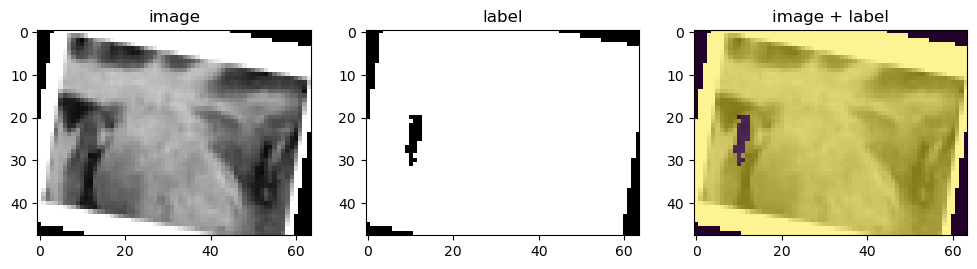

In [5]:
# visualize a training example from train_loader
batch = next(iter(train_data_loader))

batch_image = batch["image"]["data"]
batch_label = batch["label"]["data"]

print(f"The shape of the data is {batch_image.shape}")
print(f"The shape of the label is {batch_label.shape}")

plot_image_label(batch_image, batch_label, slice_idx=30)

# Define the model

In [6]:
# U-Net model from monai
model = monai.networks.nets.UNet(
    dimensions=3,
    in_channels=1,
    out_channels=3,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2),
)

# dice cross entropy loss
criterion = monai.losses.DiceCELoss(softmax=True)

# AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"])

# device for gpu or cpu training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\simon\anaconda3.gz\envs\torch-v2-gpu\lib\site-packages\monai\utils\deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)


# Training Loop

First define the Trainer object and then call Trainer.training_loop!

In [7]:
# defining the trainer object
trainer = Trainer(
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    **config
)

Trainer summary:
  -Model: UNet
  -Loss function: DiceCELoss
  -Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)
  -Device: cuda
  -Epochs: 10
  -Early stopping: None
  -Train from checkpoint: None
  -Fine tune: False
  -Best models dir: best_models
  -Mixed precision: True
  -Nit: None
  -Random seed: 42



In [9]:
# start the training loop
trainer.training_loop()

Starting training...

Epoch 1/10, train loss: 0.2593, val loss: 0.2431
Epoch 2/10, train loss: 0.2678, val loss: 0.2340
Epoch 3/10, train loss: 0.2345, val loss: 0.2367
Epoch 4/10, train loss: 0.2435, val loss: 0.2342
Epoch 5/10, train loss: 0.2362, val loss: 0.2144
Epoch 6/10, train loss: 0.2289, val loss: 0.2120
Epoch 7/10, train loss: 0.2284, val loss: 0.2179
Epoch 8/10, train loss: 0.2440, val loss: 0.2179
Epoch 9/10, train loss: 0.2474, val loss: 0.2082
Epoch 10/10, train loss: 0.2089, val loss: 0.2056

Best validation loss: 0.2056
Saving the last model...


# Testing the model to see the predictions

In [16]:
# load previously trained model from path
model_path = r"best_models\my_model.pth"


inf_model = model
inf_model.load_state_dict(torch.load(model_path))
inf_model.to(device)
inf_model.eval()
print("")

In [23]:
with torch.no_grad():
    # load first test sample
    sample = next(iter(test_data_loader))["image"]["data"]

    # perform inference and get the argmax for the final prediction
    output = inf_model(sample.to(device))
    output_argmax = torch.argmax(output, dim=1, keepdim=True)

print(f"The shape of the sample is {sample.shape}")
print(f"The shape of the output is {output.shape}")
print(f"The shape of the output argmax is {output_argmax.shape}")

The shape of the sample is torch.Size([16, 1, 48, 64, 48])
The shape of the output is torch.Size([16, 3, 48, 64, 48])
The shape of the output argmax is torch.Size([16, 1, 48, 64, 48])


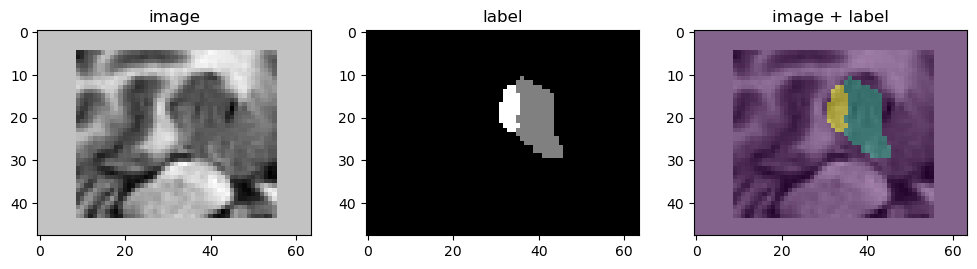

In [24]:
# plot the input, the inferred output and the overlay of the two
plot_image_label(sample, np.array(output_argmax.cpu()), slice_idx=20)

# Fine-tuning thoughts

To understand how to fine tune the model, I decided to print the model structure and shapes of the parameters it is made of. Then I saw that the last 2 sets of parameters corresponded to the last ConvTranspose3d and the corresponding bias, with shapes `torch.Size([16, 3, 3, 3, 3])` and `torch.Size([3])`. 

Hence I decided to freeze all the other weights and only keep thos for the fine-tuning.

In [13]:
model

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): Instanc

In [14]:
for param in list(model.parameters()):
    print(param.shape)

torch.Size([8, 1, 3, 3, 3])
torch.Size([8])
torch.Size([1])
torch.Size([16, 8, 3, 3, 3])
torch.Size([16])
torch.Size([1])
torch.Size([32, 16, 3, 3, 3])
torch.Size([32])
torch.Size([1])
torch.Size([64, 32, 3, 3, 3])
torch.Size([64])
torch.Size([1])
torch.Size([96, 16, 3, 3, 3])
torch.Size([16])
torch.Size([1])
torch.Size([32, 8, 3, 3, 3])
torch.Size([8])
torch.Size([1])
torch.Size([16, 3, 3, 3, 3])
torch.Size([3])
